In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [12]:
import random
p = 0.01  # 1% of the lines
# keep the header, then take only 10% of lines
# if random from [0,1] interval is greater than 0.1 the row will be skipped
df = pd.read_csv(
         'learning_traces.13m.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128800 entries, 0 to 128799
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   p_recall           128800 non-null  float64       
 1   timestamp          128800 non-null  datetime64[ns]
 2   delta              128800 non-null  int64         
 3   user_id            128800 non-null  object        
 4   learning_language  128800 non-null  object        
 5   ui_language        128800 non-null  object        
 6   lexeme_id          128800 non-null  object        
 7   lexeme_string      128800 non-null  object        
 8   history_seen       128800 non-null  int64         
 9   history_correct    128800 non-null  int64         
 10  session_seen       128800 non-null  int64         
 11  session_correct    128800 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 11.8+ MB


In [13]:
# before we try to learn good values for theta 
# we need to construct x

# x = information a students history learning a certain word

df.iloc[0,:]

p_recall                                          1.0
timestamp                         2013-02-28 20:11:14
delta                                         7239420
user_id                                        u:dDwF
learning_language                                  es
ui_language                                        en
lexeme_id            25a5cb63448fad016a8eb4e3578ec3d4
lexeme_string                   pollo/pollo<n><m><sg>
history_seen                                        4
history_correct                                     3
session_seen                                        1
session_correct                                     1
Name: 0, dtype: object

In [14]:
# (df['p_recall'] == (df['session_correct'])/(df['session_seen'])).sum() == df.shape[0]

# p_recall is the ratio of session_correct/session_seen

# p_recall is "y" "ground truth"

# predicted_p_recall is "y_hat" "prediction"

# error(p_recall,predicted_p_recall) <- we want this to be as small as possible

# if we can very reliably predict p_recall, what is the value of this in real-life terms?


In [15]:
# get parts of speech

def lexeme_df(filename):

    import re
    df_single_col = pd.read_csv(filename, delimiter='\t', header=None, names=['line'])

    def split_line(line):
        parts = re.split(r'\s+', line, maxsplit=2)
        if len(parts) == 3:
            return parts
        return [None, None, None]

    df_split = df_single_col['line'].apply(split_line)
    df = pd.DataFrame(df_split.tolist(), columns=['lexeme', 'category', 'meaning'])

    return df

In [16]:
lexemes = lexeme_df('lexeme_reference.txt')
lexemes.head()

,lexeme,category,meaning
0,aa,animacy,Animate
1,acr,adjective,Acronym
2,adj,POS,Adjective
3,adv,POS,Adverb
4,al,other,Other (altre)


In [17]:
lexemes['lexeme'].nunique()

92

In [18]:
# one-hot encoding
# dummy variables / indicator variables

# df.loc[0,"lexeme_string"]

"<det><def><nt><sg><nom>"

# det, df, nt, sg, nom + 87 more 

# word | det | def | nt | sg | nom | ...
# das  |  1  | 1   | 1  | 1  |  1  | 0 ...



# look for the first <, remove everything to the left
# then remove <, >

# 

def extract_right_of_lt(text):
    import re
    match = re.search(r'<(.*)', text)
    return match.group(1) if match else ''




In [19]:
df['lexeme_string'] = df['lexeme_string'].apply(extract_right_of_lt)
df['lexeme_string'] = df['lexeme_string'].str.replace("<"," ")
df['lexeme_string'] = df['lexeme_string'].str.replace(">","")
df['lexeme_string'] = df['lexeme_string'].str.replace("*","")
df['lexeme_string'] = df['lexeme_string'].str.replace("/","")
df['lexeme_string']

0                      n m sg
1         sfagasalho n m numb
2             vbser pri p3 sg
3               prn pos mf sp
4             vbser pri p1 sg
                 ...         
128795                 n f sg
128796                n mf sg
128797               adj m sg
128798                 n m sg
128799       det def f sg nom
Name: lexeme_string, Length: 128800, dtype: object

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
vectorized_words = vectorizer.fit_transform(df['lexeme_string'])
vectorized_df = pd.DataFrame(vectorized_words.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

/Users/arad/mambaforge/envs/sr/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [33]:
# no longer optimizing this for now,
# i want to talk about specifying the model
# we'll return to this

vectorized_df.head()

,@adv:a_peu_pres,@adv:a_posteriori,@adv:au_dela,@adv:au_moins,@adv:en_fait,@adv:en_general,@adv:peut_etre,@adv:por_favor,@adv:por_supuesto,@adv:s_il_te_plait,...,sup,sw,tn,vaux,vbdo,vbhaver,vblex,vblex+ort,vbmod,vbser
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [69]:
vectorized_df.sum().sort_values()

@adv:a_peu_pres        1
sfentendre             1
sfposizione            1
sfentrar               1
sfposition             1
                   ...  
vblex              22451
pl                 22609
m                  23744
n                  54932
sg                 75750
Length: 1515, dtype: int64

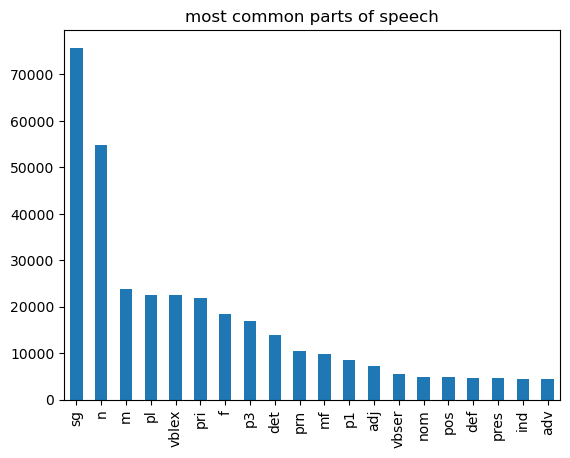

In [39]:
# curious about most common parts of speech.
# how different parts of speech correspond to rate of correct responses

#
vectorized_df.sum().sort_values(ascending=False)[0:20].plot(kind = "bar",title="most common parts of speech")
plt.show()


In [40]:
# p_recall 

df = pd.concat([df,vectorized_df],axis=1)
df.shape

(128800, 1527)

In [42]:
df.drop(columns = ['lexeme_string'],inplace=True)

In [66]:
grp_by_columns = list(df.columns[~df.columns.isin(['p_recall','delta','user_id','timestamp',"history_seen", "history_correct", "session_seen",  "session_correct"])])

"""
select avg(p_recall)
from df
group by var1

select avg(p_recall)
from df
group by var2

...

select avg(p_recall)
from df
group by varn

"""

"""

select avg(p_recall)
from df
group by var1, ..., varn

"""

# 1515 binary vectors (one for each part of speech)

# 0 avg(p_recall)
# 1 avg(p_recall)

# df.drop(columns = grp_by_columns).mean(axis=1)



# df[grp_by_columns].mean(axis = 1)

list_of_recall_variation_by_column = []

for col in grp_by_columns:

    variation_of_means = df.groupby(col)['p_recall'].mean().std()

    variation_dict = {"column_name":col,
                      "variation_of_means":variation_of_means}

    list_of_recall_variation_by_column.append(variation_dict)

recall_variation_by_column = pd.DataFrame(list_of_recall_variation_by_column)
    
# col_name, std of group means

In [82]:
# should start with a really simple feature vector
# (history_seen, history_correct)

simple_df = df[['p_recall','history_seen','history_correct']]


# input_dim = 2

In [23]:
# h_hat = 2**(theta*x)

# theta = [1,3]
# x = [10,5]

# 10 + 15 = 25

# h_hat = 2**25
# predicted_p_recall = 2**(-1*(2/(2**25))) = 1

# we need an error function to quantify how wrong we are

# (p_recall - predicted_p_recall)**2 <- error
# predicted_p_recall = 2**(-1*(delta/predicted_half_life))
# predicted_half_life = 2**(theta*x)


# given
# p_recall is given
# delta is given
# x is given

# we don't have theta

# we are going initialize theta with some random numbers
# so then we have theta

# once we have theta we can calculate the error
# and start learning

# to-do

# write formulas for predicted half_life and predicted p_recall
# write formula for loss function
# and import an optimizer 
# run the optimizer on the loss function + our data

In [24]:
# going to use pytorch
# we are using custom loss function and our model is not one of the standard ML models, like linear regression 

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim

In [71]:
# create a fresh instance of SpacedRepetition model
# what happens 
# mymodel = SpacedRepetition(2)
# under the hood
# theta = [theta1,theta2]

test_theta = nn.Linear(2,1,bias=False)
print(test_theta)



Linear(in_features=2, out_features=1, bias=False)


In [72]:
class SpacedRepetition(nn.Module):
    
    def __init__(self, input_dim):

        super(SpacedRepetition, self).__init__()
        self.theta = nn.Linear(input_dim, 1, bias=False)

    def forward(self, x):
        # estimating h_hat = 2^(theta . x)
        theta_x = self.theta(x)  # dot product of theta and x
        h_hat = torch.pow(2, theta_x)
        return h_hat

def spaced_repitition_loss(p, p_hat, h, h_hat, theta, alpha, lambda_reg):
    loss_p = torch.mean((p_hat - p) ** 2)
    loss_h = torch.mean((h_hat - h) ** 2)
    reg_term = lambda_reg * torch.sum(theta ** 2)
    total_loss = loss_p + alpha * loss_h + reg_term
    return total_loss

In [27]:
# object oriented programming

# python is a very flexible programming language

# one thing it lets you do is define things called Classes

# suppose you are a game developer
# designing a world for your game
# and your world has trees
# you write a tree class
# tree class defines what attributes trees can have
# tree: height, color, bears_fruit, number of leaves, ...

# tree_A = tree(height = 100, color = green, bears_fruit = false, number of leaves = 1800)

# tree class exists
# new class called MagicTrees

# class MagicTree(Tree):
# super(MagicTree, self).__init__()

# MagicTree is called a sub-class of Tree
# Tree is a superclass of MagicTree

# linear regression is implemented as a class
# result = smf.ols("y ~ x",data=df)
# result.summary
# result.params
# ....

# class SpacedRepetition(nn.Module)
# super(SpacedRepetition, self).__init__()

# inheritance


# __init__(self, input_dim) "dunder method" "double underscore method"


In [73]:
mymodel = SpacedRepetition(2)

In [87]:
np.dot(mymodel.theta.weight[0].detach().numpy(),simple_df[['history_seen','history_correct']].iloc[0,:])

0.3174341209232807

In [ ]:
# .317

# 2**(.317)
# predicted_half_life = 1.24
# predicted_p_recall = 2**(-1*(83/1.24)) = 0
# real p_recall = 1

# (real p_recall - predicted p recall)**2 = 1

# after optimization
# hopefully we have thetas that produce a predicted p recall that is closer to the truth

# forward pass

# 128,000 records
# each has history_seen, history_correct
# x_i = [history_seen, history_correct] for i in range(128000)
# y_i = p recall for ith person
# using theta and x_i we take a dot product theta*x_i = z_i
# predicted_hat_i = 2**(z_i)
# delta is the last time (in days) that they saw the word
# predicted_p_recall_i = 2**(-1*(delta/predicted_hat_i))
# predicted_p_recall_i is our "final output"
# now we do it for i = 1, ..., i = 128,000
# measure how wrong we are
# (p_recall_i - predicted_p_recall_i)**2 <- there's more to the error function but this what makes it go
# add it up for i = 1 , ..., i = 128,000
# ???????? optimization
# we have a new theta - new theta will hopefully yield smaller error
# rinse and repeat until error stops going down.
# then you have your model.



In [83]:
# half_life = 2**(theta*x)
#
simple_df[['history_seen','history_correct']].iloc[0,:]

history_seen       4
history_correct    3
Name: 0, dtype: int64

In [92]:
df.loc[0,"delta"]/60/60/24
# df.columns.to_list()[0:10]

83.78958333333334

In [94]:
df.loc[0,'p_recall']

1.0